## FrameFlow Video Classification of the UCF101 Full Dataset
#### Using the EfficientNetB0 pre-trained model with adapated layers for CNN


FrameFlow: Video Classification with Pre-trained CNNs

This project, titled 'FrameFlow', utilizes the power of convolutional neural networks (CNNs) 
pre-trained on large datasets to perform video classification tasks. The focus of FrameFlow 
is to apply transfer learning techniques to adapt these sophisticated models to the domain 
of action recognition in video data.

Key Components:
- Dataset Preparation: Organize and prepare video data, extracting frames and corresponding labels.
- Model Selection: Employ EfficientNetB0, a pre-trained model known for its efficiency and accuracy.
- Transfer Learning: Fine-tune the pre-trained model on a specific subset of the UCF101 dataset, targeting action recognition.
- Evaluation: Assess model performance using metrics such as accuracy, F1 score, and a confusion matrix.

By leveraging pre-trained models, FrameFlow seeks to minimize the need for extensive computational resources while maintaining high levels of accuracy. This approach is particularly beneficial when working with limited datasets or aiming for rapid prototyping.

In [1]:
# DataSet Source : https://www.crcv.ucf.edu/research/data-sets/ucf101/

In [2]:
# Setup the notebook.
# If using Anaconda then install TensorFLow 2.10.0 for this to work
# pip install -U "tensorflow>=2.10.0"

In [3]:
import pathlib
import os
import einops
from pathlib import PosixPath
import numpy as np
import cv2
import random
import tensorflow as tf
import collections
import keras
from keras import layers
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping

### Set and Check GPU Settings - PC Only

In [4]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.1


In [5]:
os.environ["CUDA_HOME"] = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.1"
os.environ["CUDA_PATH"] = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.1\bin"

In [6]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_22:08:44_Pacific_Standard_Time_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [7]:
print(tf.__version__)

2.10.0


In [8]:
print(tf.config.list_physical_devices('GPU'))
# tf.debugging.set_log_device_placement(True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Prepare and load the datasest

In [9]:
# From the UCF101 dataset website they have provided a list for tbe datasets
# https://www.crcv.ucf.edu/data/UCF101.php

# Set globally thge base directory of the full dataset
base_dir = Path('UCF101')  # Update this path to your dataset location

In [10]:
# Check Directory structure of the dataset

def check_directory_structure(base_dir):
    base_path = pathlib.Path(base_dir)
    if not base_path.exists():
        print(f"Base directory {base_dir} does not exist.")
        return

    # Recursively list video files
    video_files = list(base_path.rglob('*.avi'))  # Assuming all videos are in .avi format
    if not video_files:
        print(f"No video files found in {base_dir}")
        return

    print(f"Found {len(video_files)} video files in {base_dir}")

base_dir = './UCF101/'  # Replace this with the path to your base directory
check_directory_structure(base_dir)


Found 13320 video files in ./UCF101/


In [11]:
# Manual check if needed on the dataset folder to see contents:-
# !find ./UCF101 # List within notebook sub-folder file views

In [12]:
# Load class list and return dictionary
def load_class_list(class_file):
    class_map = {}
    with open(class_file, 'r') as file:
        for line in file:
            index, class_name = line.strip().split(' ')
            # class_map[int(index)] = class_name
            class_map[int(index) - 1] = class_name  # Subtract 1 to make indices zero-based
    return class_map

# Neater class map print
def print_class_map(class_map):
    print("Class Index | Class Name")
    print("-" * 30)  # Print a separator line
    for index, name in class_map.items():
        print(f"{index:>11} | {name}")


# Usage
class_map = load_class_list('./classInd.txt')

# Print the class map
print_class_map(class_map)
print ("\n There are", len(class_map), "classes. Index starts at zero for TensorFlow")

Class Index | Class Name
------------------------------
          0 | ApplyEyeMakeup
          1 | ApplyLipstick
          2 | Archery
          3 | BabyCrawling
          4 | BalanceBeam
          5 | BandMarching
          6 | BaseballPitch
          7 | Basketball
          8 | BasketballDunk
          9 | BenchPress
         10 | Biking
         11 | Billiards
         12 | BlowDryHair
         13 | BlowingCandles
         14 | BodyWeightSquats
         15 | Bowling
         16 | BoxingPunchingBag
         17 | BoxingSpeedBag
         18 | BreastStroke
         19 | BrushingTeeth
         20 | CleanAndJerk
         21 | CliffDiving
         22 | CricketBowling
         23 | CricketShot
         24 | CuttingInKitchen
         25 | Diving
         26 | Drumming
         27 | Fencing
         28 | FieldHockeyPenalty
         29 | FloorGymnastics
         30 | FrisbeeCatch
         31 | FrontCrawl
         32 | GolfSwing
         33 | Haircut
         34 | Hammering
         35 | Hamme

In [13]:
# Function to recursively find all video files with .avi extension
def find_avi_files(directory):
    avi_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".avi"):
                avi_files.append(os.path.join(root, file))
    return avi_files

# Get all .avi video files within the dataset directory
avi_video_files = find_avi_files(base_dir)

In [14]:
# Display the total number of .avi files found and the first 10 file names as a sample
total_videos = len(avi_video_files)
sample_videos = avi_video_files[:10]  # Get the first 10 video file names as a sample

total_videos, sample_videos

(13320,
 ['./UCF101/UCF-101\\ApplyEyeMakeup\\v_ApplyEyeMakeup_g01_c01.avi',
  './UCF101/UCF-101\\ApplyEyeMakeup\\v_ApplyEyeMakeup_g01_c02.avi',
  './UCF101/UCF-101\\ApplyEyeMakeup\\v_ApplyEyeMakeup_g01_c03.avi',
  './UCF101/UCF-101\\ApplyEyeMakeup\\v_ApplyEyeMakeup_g01_c04.avi',
  './UCF101/UCF-101\\ApplyEyeMakeup\\v_ApplyEyeMakeup_g01_c05.avi',
  './UCF101/UCF-101\\ApplyEyeMakeup\\v_ApplyEyeMakeup_g01_c06.avi',
  './UCF101/UCF-101\\ApplyEyeMakeup\\v_ApplyEyeMakeup_g02_c01.avi',
  './UCF101/UCF-101\\ApplyEyeMakeup\\v_ApplyEyeMakeup_g02_c02.avi',
  './UCF101/UCF-101\\ApplyEyeMakeup\\v_ApplyEyeMakeup_g02_c03.avi',
  './UCF101/UCF-101\\ApplyEyeMakeup\\v_ApplyEyeMakeup_g02_c04.avi'])

Load Video Filenames and Labels: First, we need to create a list of video filenames and their corresponding labels from the dataset. Based on the format in trainlist01.txt you provided, each line contains the relative path to a video file followed by its label index​​.

Create a DataFrame: We'll use these lists to create a pandas DataFrame. This DataFrame will have two columns: one for the video file paths and another for their corresponding labels.

Split the DataFrame: With the DataFrame ready, we'll use train_test_split from scikit-learn to split the DataFrame into training, validation, and testing sets. A common approach is to first split the data into training+validation and testing sets, and then further split the training+validation set into separate training and validation sets.

Verify the Splits: It's a good practice to check the size of each split and ensure that the distribution of classes is balanced across them.

In [15]:
# Initialize a list to hold tuples of (video_file_path, label_index)
video_labels = []

for video_path in avi_video_files:
    filename = os.path.basename(video_path)  # Get the filename from the full path
    parts = filename.split('_')
    
    if len(parts) > 3:  # Ensuring there are enough parts in the filename to extract class name
        # Extract and format the class name to match the class map's naming convention
        class_name = '_'.join(parts[1:-2]).replace("HandStandPushups", "HandstandPushups")
        
        # Find the class label associated with the class name in a case-insensitive manner
        class_label = None
        for label, name in class_map.items():
            if name.lower() == class_name.lower():
                class_label = label
                break

        if class_label is not None:
            video_labels.append((video_path, class_label))
        else:
            print(f"Warning: No label found for class name '{class_name}' in video '{video_path}'.")
    else:
        print(f"Invalid filename format for video '{video_path}'. Expected format 'v_ClassName_gxx_cxx.avi'.")

# Now, `video_labels` will contain tuples of (video_path, label)
video_labels[0:5]
len(video_labels)
# This should now show the corresponding file path and label (relating to action) for the first ten elemenets in the tuple
# Using Tuples is a good idea as we don't want to modify the set or have something modifying it to retain integrity

13320

In [16]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into training, validation, and testing sets is a common practice in machine learning. 
# This approach helps in developing a model that generalizes well to new, unseen data by ensuring that 
# the model is trained on one set of data, its hyperparameters are tuned based on its performance on another 
# set of data (validation set), and its final performance is evaluated on a completely unseen set of data (testing set).

# First Split: Training + Validation and Testing Sets
# The first call to train_test_split divides the dataset into two parts:
# 1. A combined set of training and validation data (train_val_paths and train_val_labels) - This is used for training the model 
#    and tuning its hyperparameters.
# 2. A testing set (test_paths and test_labels) - This set is kept aside and not used during the training or validation 
#    processes. It is used only after the model training and hyperparameter tuning are complete, to evaluate the 
#    model's performance on data it has never seen before. The test_size=0.2 parameter specifies that 20% of the 
#    data is reserved for this purpose.

# Second Split: Training and Validation Sets
# The second call to train_test_split further divides the combined training and validation set obtained from the 
# first split into separate training and validation sets:
# 1. Training set (train_paths and train_labels) - This set is used to train the model, i.e., to adjust the model's 
#    weights based on the given data.
# 2. Validation set (val_paths and val_labels) - This set is used to evaluate the model's performance during training. 
#    The performance on the validation set is a good indicator of how well the model is learning and generalizing from 
#    the training data. It also helps in identifying issues like overfitting. The test_size=0.25 parameter here means 
#    that 25% of the remaining data (after setting aside the test set) is used for validation.

# These splits are crucial for the iterative process of model training, validation, and testing, ensuring that the 
# model not only learns well but also generalizes well to new data, thus providing a reliable measure of its 
# real-world performance.


# Separate video file paths and labels
video_paths, labels = zip(*video_labels)

# First split: Separate the testing set from the training and validation set
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    video_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# Second split: Separate the training set from the validation set
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.25, stratify=train_val_labels, random_state=42)

# Now we have:
# - train_paths and train_labels for the training set
# - val_paths and val_labels for the validation set
# - test_paths and test_labels for the testing set

# Check the number of records in each set
num_train_records = len(train_paths)
num_val_records = len(val_paths)
num_test_records = len(test_paths)

print(f"Number of records in the training set: {num_train_records}")
print(f"Number of records in the validation set: {num_val_records}")
print(f"Number of records in the testing set: {num_test_records}")

# Output the first 5 records from each set
print("\nFirst 5 records in the training set:")
print(train_paths[:5])

print("\nFirst 5 records in the validation set:")
print(val_paths[:5])

print("\nFirst 5 records in the testing set:")
print(test_paths[:5])



Number of records in the training set: 7992
Number of records in the validation set: 2664
Number of records in the testing set: 2664

First 5 records in the training set:
['./UCF101/UCF-101\\BenchPress\\v_BenchPress_g04_c06.avi', './UCF101/UCF-101\\CuttingInKitchen\\v_CuttingInKitchen_g07_c03.avi', './UCF101/UCF-101\\PlayingGuitar\\v_PlayingGuitar_g20_c07.avi', './UCF101/UCF-101\\PlayingCello\\v_PlayingCello_g12_c01.avi', './UCF101/UCF-101\\IceDancing\\v_IceDancing_g25_c01.avi']

First 5 records in the validation set:
['./UCF101/UCF-101\\PlayingDhol\\v_PlayingDhol_g09_c07.avi', './UCF101/UCF-101\\TennisSwing\\v_TennisSwing_g23_c01.avi', './UCF101/UCF-101\\RopeClimbing\\v_RopeClimbing_g13_c04.avi', './UCF101/UCF-101\\HammerThrow\\v_HammerThrow_g04_c06.avi', './UCF101/UCF-101\\SoccerPenalty\\v_SoccerPenalty_g20_c01.avi']

First 5 records in the testing set:
['./UCF101/UCF-101\\BasketballDunk\\v_BasketballDunk_g18_c04.avi', './UCF101/UCF-101\\Nunchucks\\v_Nunchucks_g13_c01.avi', './UCF101

### Read video data and visualise

In [17]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [18]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 3):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [19]:
# Check that the first file in the training set Exists locally on drive
video_path = "./" + train_paths[0]
absolute_video_path = os.path.abspath(video_path)
print("Absolute video path:", absolute_video_path)
print("File exists:", os.path.exists(absolute_video_path))

Absolute video path: C:\Users\gwrip\Documents\Machine_Learning\Imperial College Business School Course\Capstone Project\MainCapstone FrameFlow\UCF101\UCF-101\BenchPress\v_BenchPress_g04_c06.avi
File exists: True


In [20]:
sample_video = frames_from_video_file(video_path, n_frames = 10)
sample_video.shape

(10, 224, 224, 3)

### Visualise data example

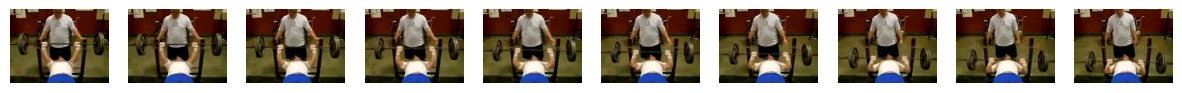

The Video path is ././UCF101/UCF-101\BenchPress\v_BenchPress_g04_c06.avi
First element in the training set ./UCF101/UCF-101\BenchPress\v_BenchPress_g04_c06.avi
First element in label path 9


In [21]:
# Use the CV2 library to display 10 frames from the example vile
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error opening video file")

# Number of frames you want to display
num_frames_to_display = 10

# Set up the matplotlib figure and axes
fig, axs = plt.subplots(1, num_frames_to_display, figsize=(15, 5))

for i in range(num_frames_to_display):
    ret, frame = cap.read()
    if ret:
        # Convert BGR to RGB for correct matplotlib display
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        axs[i].imshow(frame_rgb)
        axs[i].axis('off')
    else:
        print(f"Failed to read frame {i}")
        break

plt.show()
cap.release()

print("The Video path is", video_path)
print("First element in the training set", train_paths[0])
print("First element in label path", train_labels[0])

In [22]:
def check_for_black_frames(frames):
    black_frames_indices = []
    for i, frame in enumerate(frames):
        if np.all(frame == 0):  # Check if all pixel values in the frame are 0 (black)
            black_frames_indices.append(i)
    return black_frames_indices

# Assuming 'sample_video' contains your extracted frames
black_frames_indices = check_for_black_frames(sample_video)

if black_frames_indices:
    print(f"Black frames found at indices: {black_frames_indices}")
else:
    print("No black frames found.")


No black frames found.


In [23]:
#Open the video file
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error opening video file")
else:
    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total number of frames in the video: {total_frames}")

# Release the video capture object
cap.release()


Total number of frames in the video: 176


In [24]:
 class FrameGenerator:
    def __init__(self, paths, labels, n_frames, training=False):
        """ Initialize the frame generator with lists of video file paths and corresponding labels. """
        self.paths = paths  # List of video file paths
        self.labels = labels  # Corresponding labels for the video files
        self.n_frames = n_frames
        self.training = training

    def __call__(self):
        """ Generator function to yield frames and labels. """
        # Pair each path with its corresponding label
        path_label_pairs = list(zip(self.paths, self.labels))
        
        if self.training:
            # Shuffle the pairs if this is for training
            random.shuffle(path_label_pairs)

        for video_path, label in path_label_pairs:
            frames = frames_from_video_file(video_path, self.n_frames)  # Use your frame extraction function
            yield frames, label



Frames shape: (10, 224, 224, 3), Label: 91


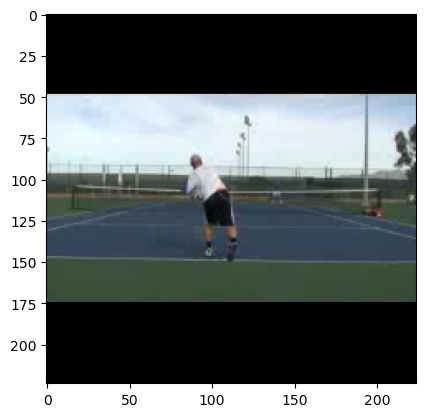

In [25]:
# Example for training data
train_fg = FrameGenerator(train_paths, train_labels, n_frames=10, training=True)

# To generate and inspect a batch of frames and its label
for frames, label in train_fg():
    print(f"Frames shape: {frames.shape}, Label: {label}")
    # Optionally, visualize a frame to inspect it
    plt.imshow(frames[0])  # Show the first frame of the first video
    plt.show()
    break  # Remove or adjust the break statement as needed


Batch 1: Frames shape: (10, 224, 224, 3), Label: 93, Class Name: TrampolineJumping


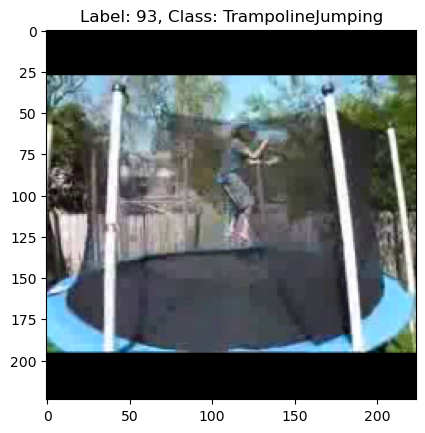

Batch 2: Frames shape: (10, 224, 224, 3), Label: 75, Class Name: Rowing


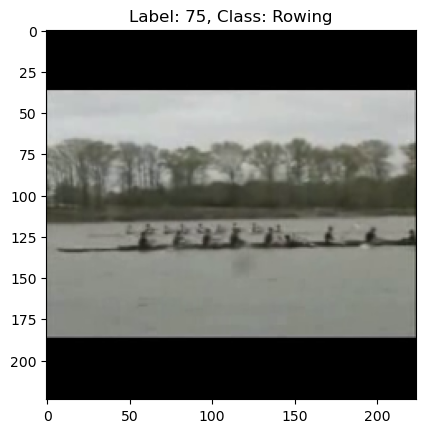

Batch 3: Frames shape: (10, 224, 224, 3), Label: 41, Class Name: HorseRiding


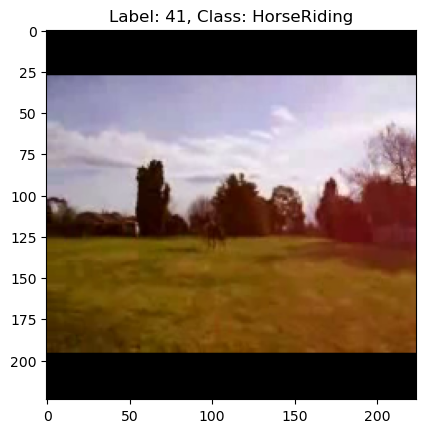

Batch 4: Frames shape: (10, 224, 224, 3), Label: 16, Class Name: BoxingPunchingBag


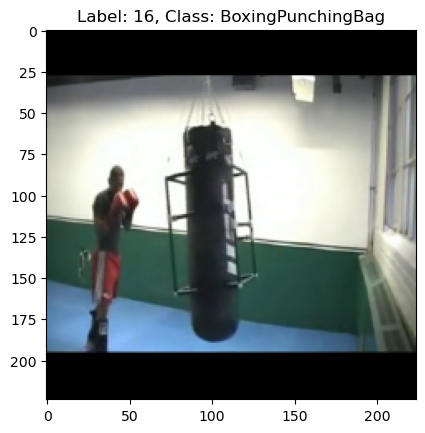

Batch 5: Frames shape: (10, 224, 224, 3), Label: 36, Class Name: HandstandPushups


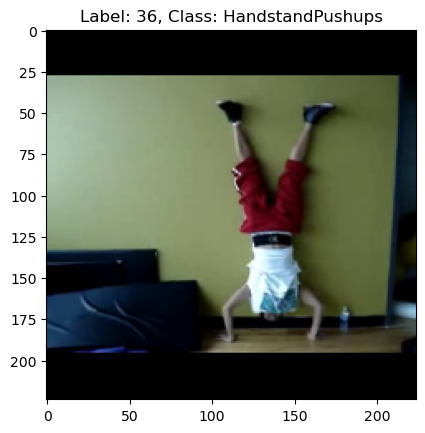

Batch 6: Frames shape: (10, 224, 224, 3), Label: 0, Class Name: ApplyEyeMakeup


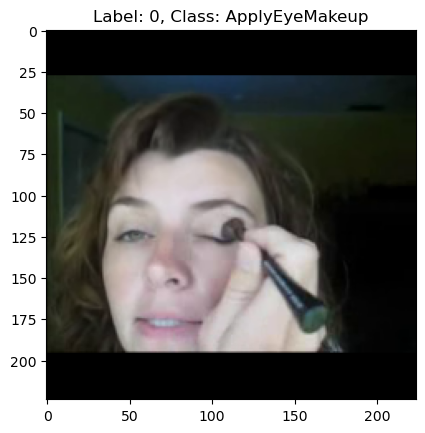

In [26]:
# Check Class names with a batch of images

# Assuming 'class_map' is mapping from class indices to class names
# Make sure it's accessible in the current scope

for i, (frames, label) in enumerate(train_fg()):
    class_name = class_map[label]  # Use the label to get the corresponding class name
    print(f"Batch {i+1}: Frames shape: {frames.shape}, Label: {label}, Class Name: {class_name}")
    plt.imshow(frames[0])  # Show the first frame of the first video in the batch
    plt.title(f"Label: {label}, Class: {class_name}")
    plt.show()

    if i >= 5:  # Adjust this as needed to inspect more or fewer batches
        break



### Dataset creation for Training

In [27]:
# Hyper parameter: number of samples to work through before updating model
# batch_size = 32
batch_size = 2

# Create TensforFLow training set

# Define the output signature for the dataset elements.
# This is necessary because the dataset is being created from a generator,
# and TensorFlow needs to know the structure and data types of the elements it will contain.
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32), # For video frames
                    tf.TensorSpec(shape = (), dtype = tf.int16)) # For labels

# Create the training dataset using a generator.

# Initialize the FrameGenerator with train_paths and train_labels
train_fg = FrameGenerator(train_paths, train_labels, n_frames=10, training=True)

# Create the training dataset using the generator with the output_signature.
train_ds = tf.data.Dataset.from_generator(
    lambda: train_fg(),  # Use a lambda to create a generator function
    output_signature=output_signature
)

# Initialize the FrameGenerator with val_paths and val_labels for the validation set
val_fg = FrameGenerator(val_paths, val_labels, n_frames=10, training=False)  # 'training' is False since it's the validation set

# Create the validation dataset using the generator with the output_signature.
val_ds = tf.data.Dataset.from_generator(
    lambda: val_fg(),  # Use a lambda to create a generator function
    output_signature=output_signature
)

AUTOTUNE = tf.data.AUTOTUNE

# Correctly configure the training dataset for performance
train_ds = (train_ds
            .shuffle(buffer_size=1000)  # Shuffle the data
            .cache()                    # Cache the data
            .batch(batch_size)          # Batch the data after caching
            .prefetch(AUTOTUNE))        # Prefetch for performance

# Correctly configure the validation dataset for performance
# Note: You typically don't need to shuffle the validation set
val_ds = (val_ds
          .batch(batch_size)           # Batch the data
          .cache()                     # Cache the data
          .prefetch(AUTOTUNE))         # Prefetch for performance


### ResNet model defintion

In [28]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [29]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

In [30]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [31]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [32]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [33]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [34]:
from keras import layers, Model

# Assuming input_shape is defined earlier
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input_layer = layers.Input(shape=(input_shape[1:]))

x = input_layer
x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(101)(x)  # Adjusted for 101 classes

model = Model(input_layer, x)


The following code if needed will print the shape of the frames and their corresponding labels for a specified number of elements in the dataset (num_elements_to_inspect). Adjust num_elements_to_inspect as needed to inspect more or fewer elements from the dataset.

```
# Define the number of elements you want to inspect
num_elements_to_inspect = 5  # Change this number as needed

# Take a specified number of elements from the dataset
sample_data = train_ds.take(num_elements_to_inspect)

# Iterate through the sample data and print the contents
for frames, label in sample_data:
    print("Frames shape:", frames.shape)  # Print the shape of frames
    print("Label:", label)  # Print the label
```

In [35]:
frames, label = next(iter(train_ds))
model.build(frames)

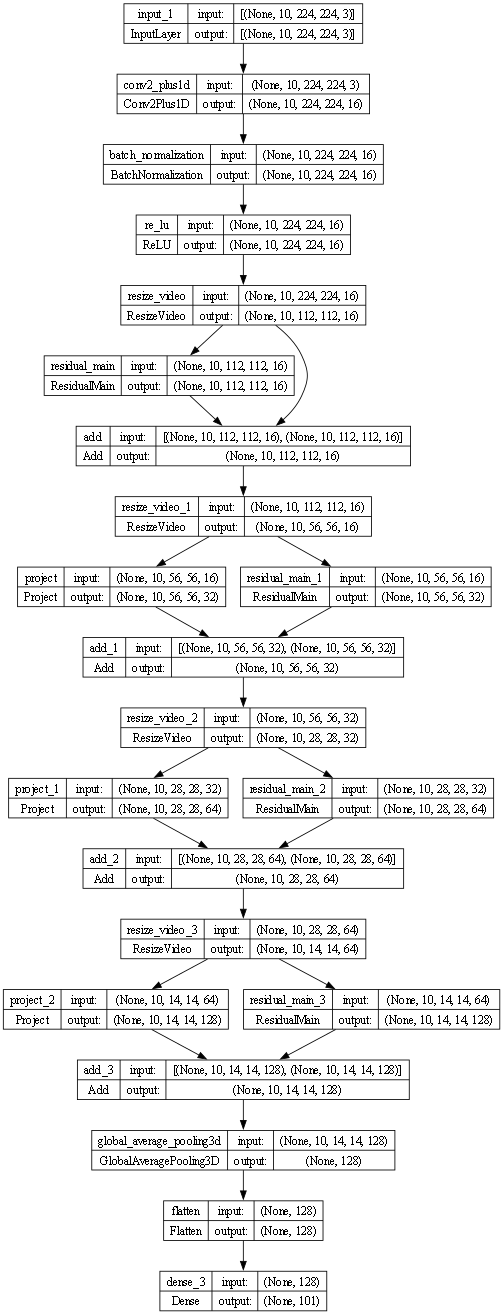

In [36]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [37]:
# Setting the learning rate to 0.0001 is more conservative to ensure that the model does not skip over minima in the loss landscape, might take longer to converge (to find optimal weights)

model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [38]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    x=train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[early_stopping]
)


Epoch 1/50
3996/3996 [==============================] - 1191s 277ms/step - loss: 4.5260 - accuracy: 0.0303 - val_loss: 4.3033 - val_accuracy: 0.0443
Epoch 2/50
3996/3996 [==============================] - 481s 120ms/step - loss: 4.0745 - accuracy: 0.0684 - val_loss: 3.8581 - val_accuracy: 0.0957
Epoch 3/50
3996/3996 [==============================] - 488s 122ms/step - loss: 3.6991 - accuracy: 0.1211 - val_loss: 3.5875 - val_accuracy: 0.1396
Epoch 4/50
3996/3996 [==============================] - 471s 118ms/step - loss: 3.4725 - accuracy: 0.1534 - val_loss: 3.3964 - val_accuracy: 0.1783
Epoch 5/50
3996/3996 [==============================] - 475s 119ms/step - loss: 3.3023 - accuracy: 0.1867 - val_loss: 3.2863 - val_accuracy: 0.1959
Epoch 6/50
3996/3996 [==============================] - 482s 121ms/step - loss: 3.1635 - accuracy: 0.2097 - val_loss: 3.1683 - val_accuracy: 0.2177
Epoch 7/50
3996/3996 [==============================] - 481s 120ms/step - loss: 3.0439 - accuracy: 0.2339 - val

### Model training

In [55]:
# Check for any labels outside the valid range in training labels
invalid_train_labels = [label for label in train_labels if label < 0 or label > 100]
print("Invalid training labels:", invalid_train_labels)

# Repeat for validation labels if necessary
invalid_val_labels = [label for label in val_labels if label < 0 or label > 100]
print("Invalid validation labels:", invalid_val_labels)


Invalid training labels: []
Invalid validation labels: []


In [71]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, None, None, None,  0         
                              3)                                 
                                                                 
 time_distributed_1 (TimeDis  (None, None, None, None,  4049571  
 tributed)                    1280)                              
                                                                 
 dense_5 (Dense)             (None, None, None, None,  129381    
                              101)                               
                                                                 
 global_average_pooling3d_2   (None, 101)              0         
 (GlobalAveragePooling3D)                                        
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non

### Evaluation of the model using test set

In [72]:
batch_size = 2 # Set to two to reduce memory impacts and keep consistent with earlier parameter set

# Assuming test_paths and test_labels are defined and prepared similarly to train_paths and train_labels
test_fg = FrameGenerator(test_paths, test_labels, n_frames=10, training=False)

test_ds = tf.data.Dataset.from_generator(
    lambda: test_fg(),
    output_signature=output_signature
).batch(batch_size).cache().prefetch(AUTOTUNE)


In [73]:
# Evaluate the trained model on the test dataset to determine its performance on unseen data.
# `model.evaluate` returns the loss value & metrics values (in this case, accuracy) for the model.
# `test_ds` is the test dataset containing the input data and the true labels.
# `test_loss` is a scalar value representing the loss of the model on the test dataset, indicating how well the model's predictions match the true labels.
# `test_accuracy` is a scalar value representing the accuracy of the model on the test dataset, calculated as the percentage of correct predictions.
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the test loss and test accuracy to get an overview of the model's performance on the test dataset.
# This helps in understanding how well the model generalizes to new, unseen data.
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


1332/1332 [==============================] - 263s 197ms/step - loss: 0.1957 - accuracy: 0.9474
Test Loss: 0.19571946561336517, Test Accuracy: 0.9474474191665649


For example if the results of model.evalaute are as follows :-

50/50 [==============================] - 44s 862ms/step - loss: 0.0981 - accuracy: 0.9800
Test Loss: 0.09812692552804947
Test Accuracy: 0.9800000190734863

 - 50/50 is the number of batches processed during eval
 - Time taken to complete evaluation 44s 
 - Loss = 0.0981
     - Final loss value on the test set, calculating the difference between the predicted values
       and the actual labels. The lower the better, at this rate the model predictions are quite
       close to to the true labels on average.
 - Accuracy = 0.98 meaning that 98 percent of the predictions made by the model on the test
   dataset were correct. High accuracy rate suggests model performs well on the testg data.
 - Test Loss and Test accracxy are reiterations of the values mentioned.
 - Model has high perdirive accuracy on the test dataset, suggesting the model has generalized
   well ro new unseen data assuming the test dataset represents real-world data the model is 
   expected to handle

In [74]:
# Generated Predictions on the test dataset to get probabilities

In [75]:
# Use the trained model to make predictions on the test dataset.
# `model.predict(test_ds)` outputs the probabilities that each test video belongs to each of the classes.
# The shape of `predicted_probabilities` is (number_of_test_videos, number_of_classes).
predicted_probabilities = model.predict(test_ds)

# Convert the predicted probabilities into class labels.
# The `np.argmax` function is used to find the index of the maximum probability for each video.
# This index corresponds to the predicted class label for each video.
# The `axis=-1` argument specifies that the function should find the index of the maximum value along the last dimension,
# which corresponds to the class probability dimension in this case.
predicted_labels = np.argmax(predicted_probabilities, axis=-1)



1332/1332 [==============================] - 38s 29ms/step


In [85]:
true_labels = []

for _, label in test_ds.unbatch().take(-1):  # .take(-1) ensures all elements are taken
    true_labels.append(label.numpy())  # Use append() for single elements

# Convert true_labels to a numpy array for consistency
true_labels = np.array(true_labels)



In [86]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

In [87]:
print(conf_matrix)

[[29  0  0 ...  0  0  0]
 [ 0 22  0 ...  0  0  0]
 [ 0  0 29 ...  0  0  0]
 ...
 [ 0  0  0 ... 26  0  0]
 [ 0  0  0 ...  0 30  0]
 [ 0  0  0 ...  0  0 24]]


In [88]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average=None)

# Assuming `class_map` is a dictionary mapping indices to class names
# Example: class_map = {0: 'ClassName0', 1: 'ClassName1', ...}

# Print the F1 scores for each class along with the class name
for i, score in enumerate(f1_score):
    class_name = class_map.get(i, f"Class {i}")  # Get the class name using the class index
    print(f"Class {i} ({class_name}): F1 Score = {score}")

# If you want the average F1 score across all classes
avg_f1_score = np.mean(f1_score)
print(f"Average F1 Score: {avg_f1_score}")


Class 0 (ApplyEyeMakeup): F1 Score = 0.983050847457627
Class 1 (ApplyLipstick): F1 Score = 0.9166666666666666
Class 2 (Archery): F1 Score = 1.0
Class 3 (BabyCrawling): F1 Score = 0.9411764705882353
Class 4 (BalanceBeam): F1 Score = 0.8837209302325582
Class 5 (BandMarching): F1 Score = 0.96875
Class 6 (BaseballPitch): F1 Score = 0.9508196721311476
Class 7 (Basketball): F1 Score = 0.9454545454545454
Class 8 (BasketballDunk): F1 Score = 1.0
Class 9 (BenchPress): F1 Score = 0.9846153846153847
Class 10 (Biking): F1 Score = 0.9056603773584906
Class 11 (Billiards): F1 Score = 1.0
Class 12 (BlowDryHair): F1 Score = 0.8461538461538461
Class 13 (BlowingCandles): F1 Score = 0.9767441860465117
Class 14 (BodyWeightSquats): F1 Score = 0.9302325581395349
Class 15 (Bowling): F1 Score = 0.9491525423728813
Class 16 (BoxingPunchingBag): F1 Score = 1.0
Class 17 (BoxingSpeedBag): F1 Score = 1.0
Class 18 (BreastStroke): F1 Score = 0.85
Class 19 (BrushingTeeth): F1 Score = 0.962962962962963
Class 20 (CleanAn

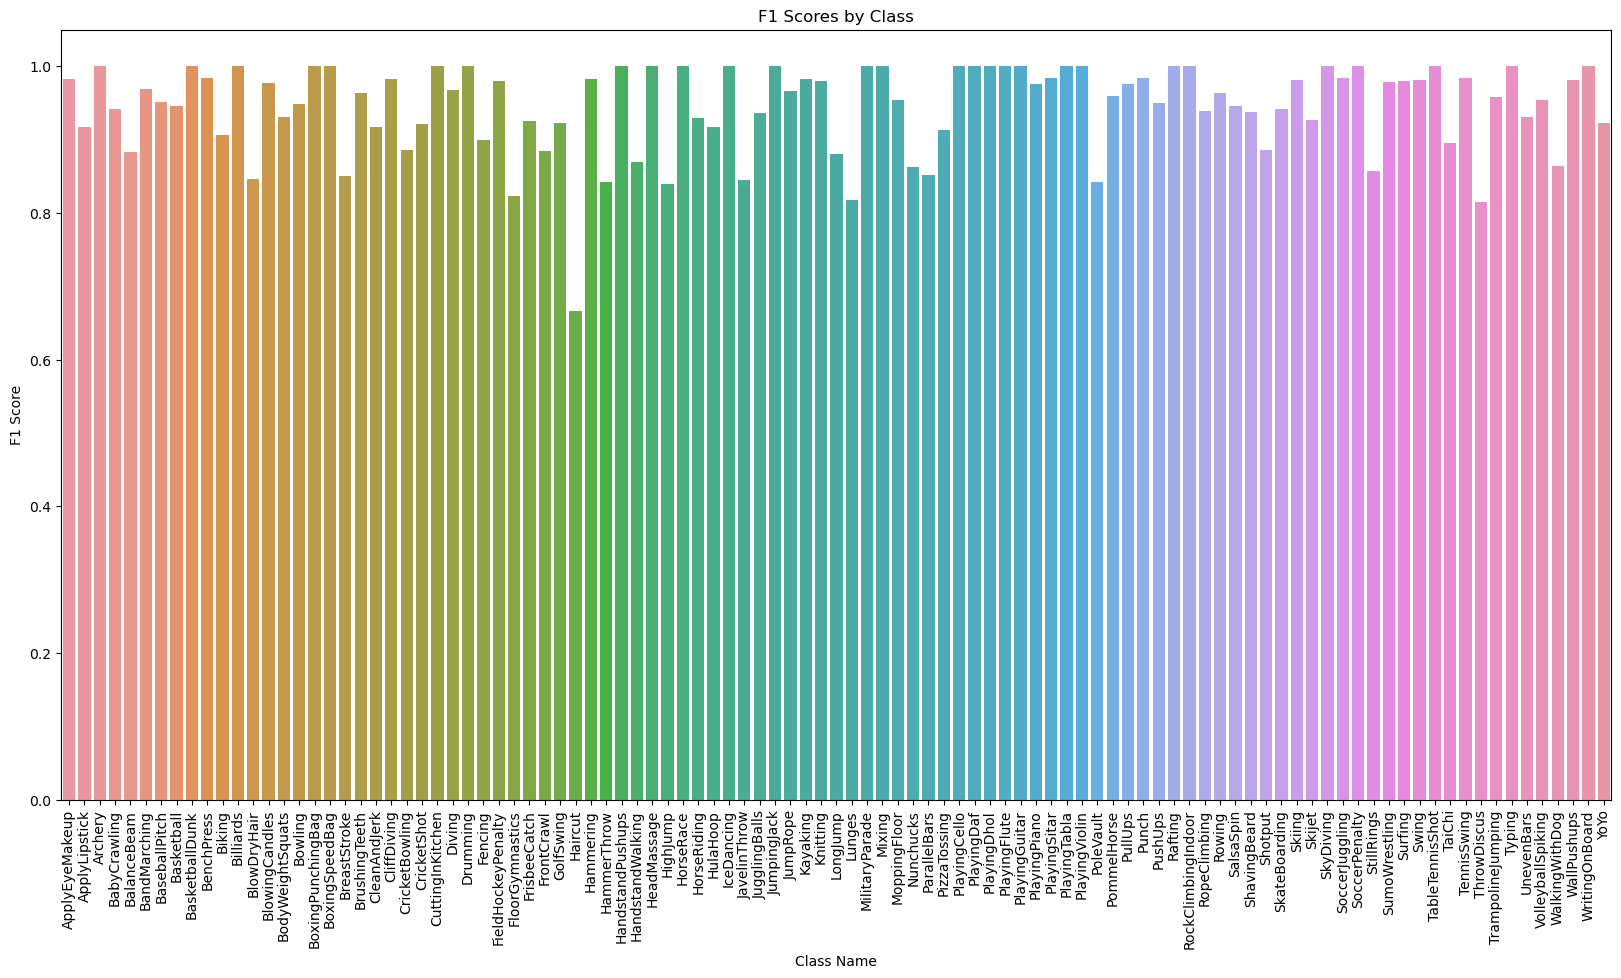

In [89]:
# Assuming 'f1_score' and 'class_map' are defined
# 'f1_score' is a list of F1 scores for each class
# 'class_map' is a dictionary mapping class indices to class names

# Convert class_map to a list of class names ordered by the class index
class_names = [class_map[i] for i in range(len(f1_score))]

# Create a bar chart
plt.figure(figsize=(20, 10))
sns.barplot(x=class_names, y=f1_score)
plt.xticks(rotation=90)  # Rotate class names for better readability
plt.xlabel('Class Name')
plt.ylabel('F1 Score')
plt.title('F1 Scores by Class')
plt.show()

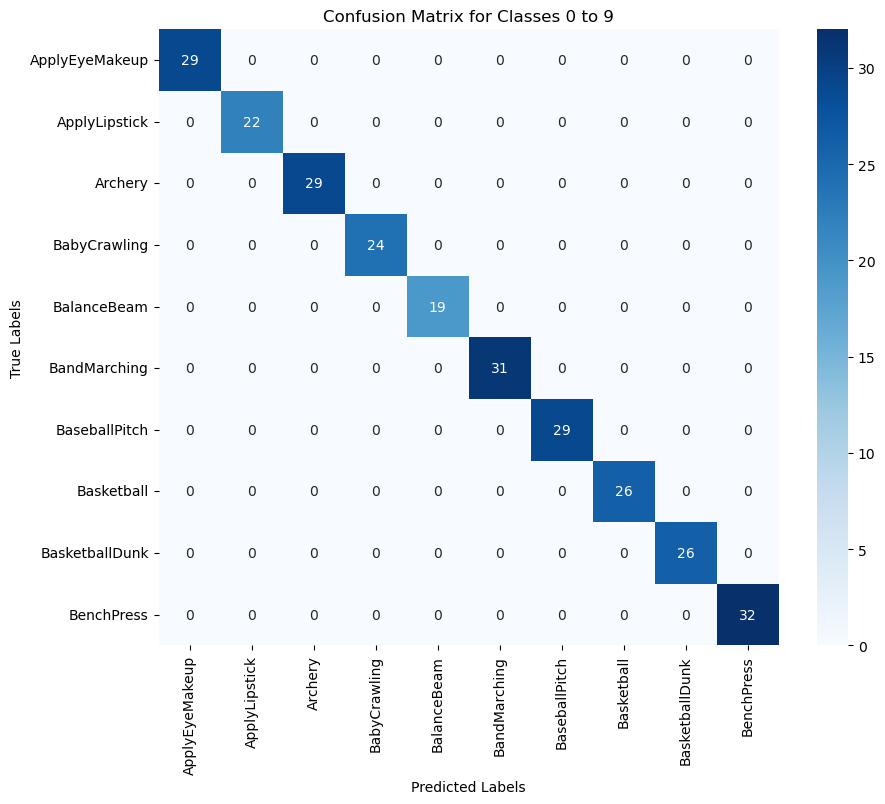

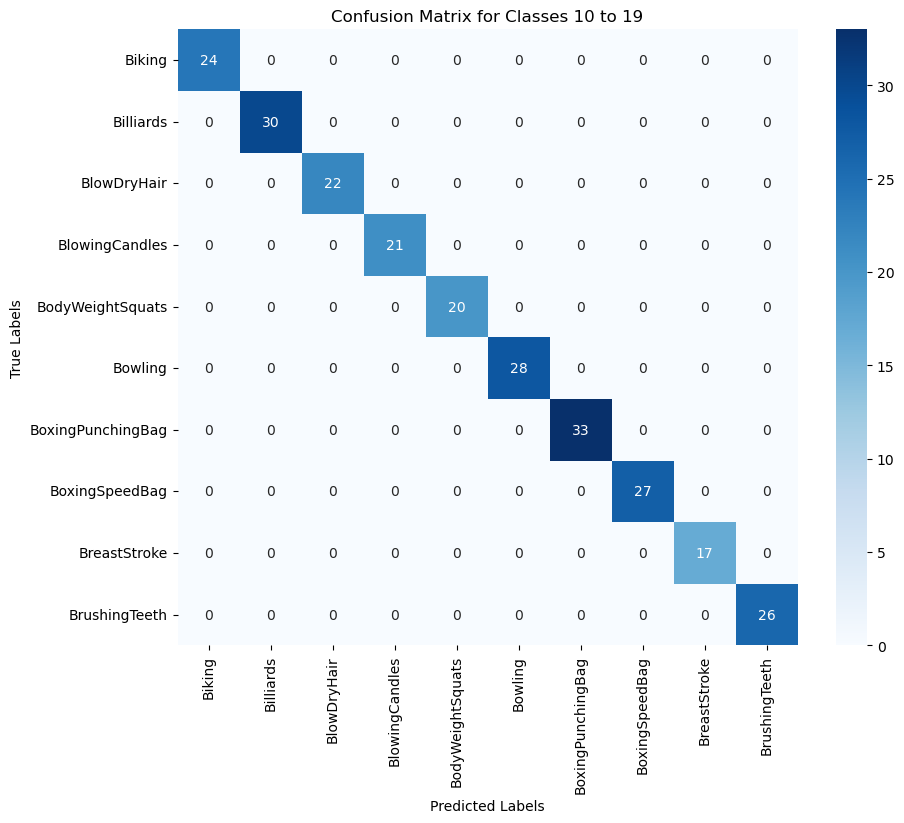

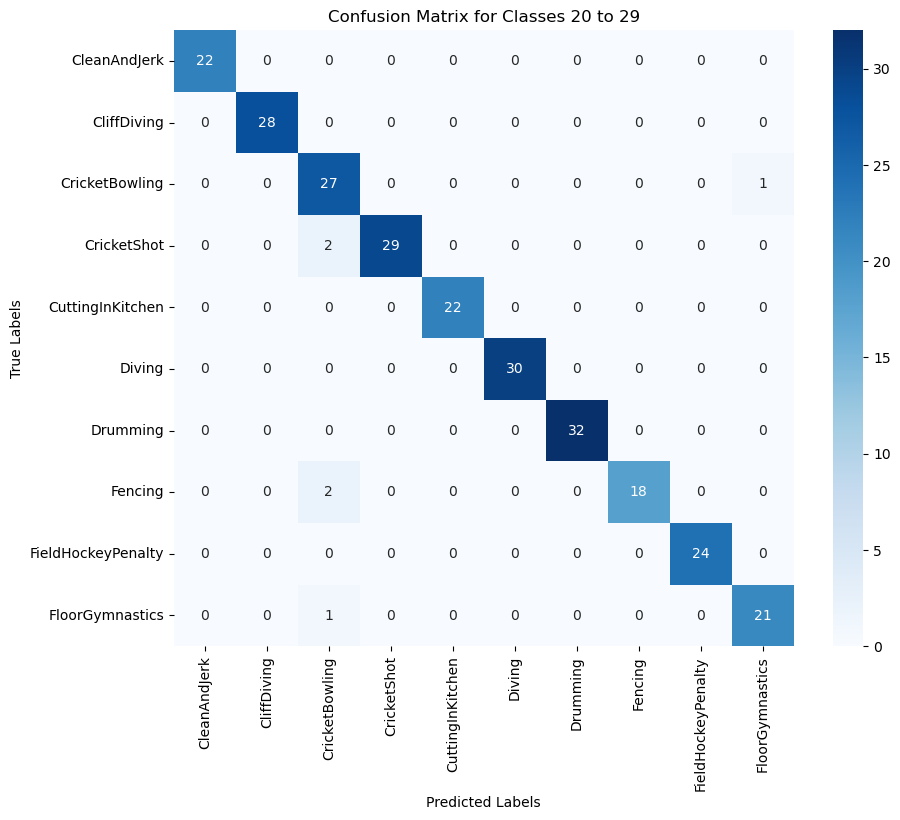

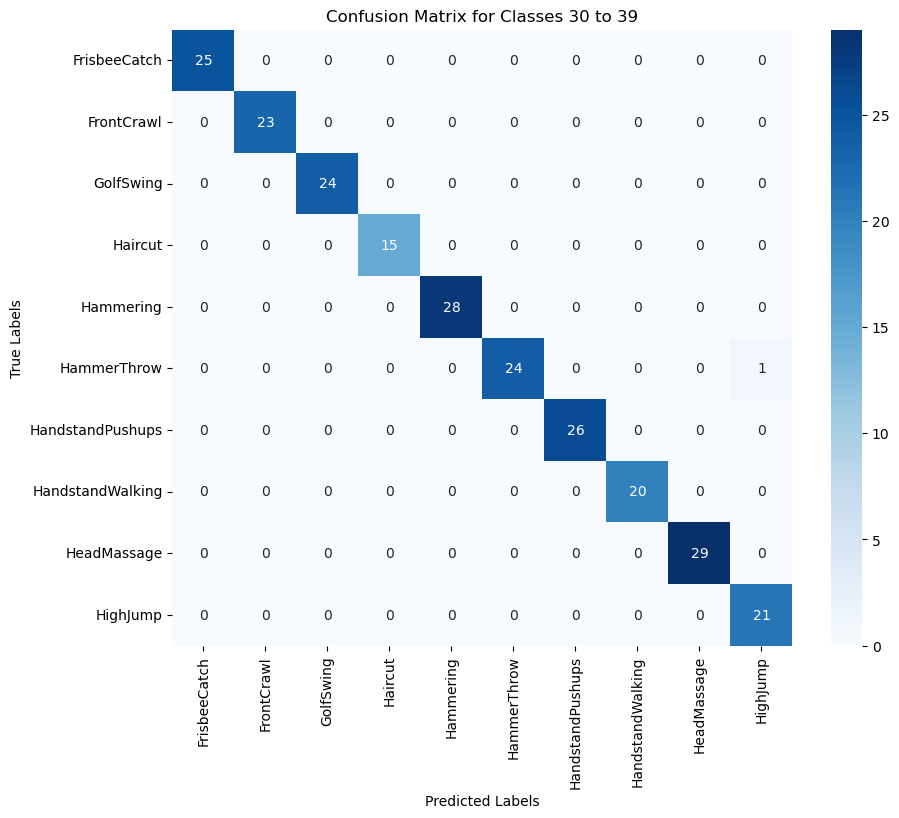

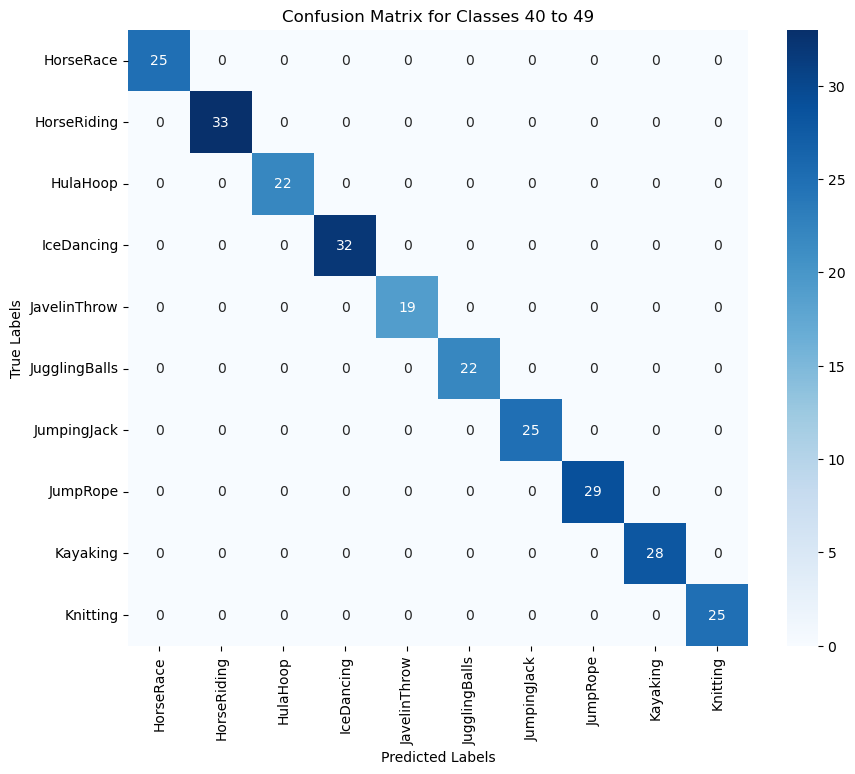

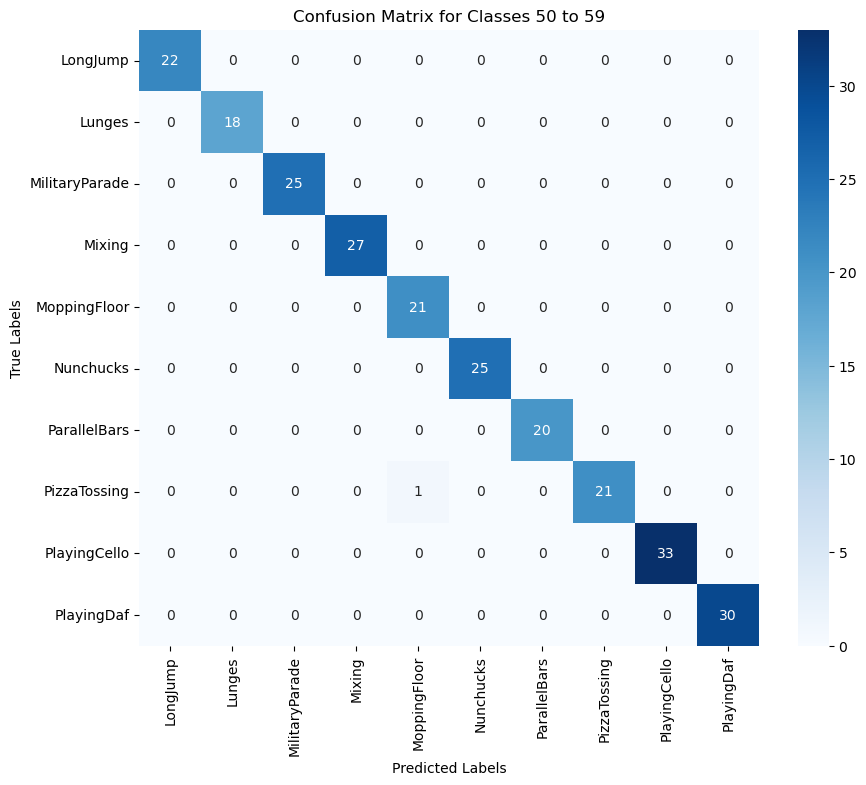

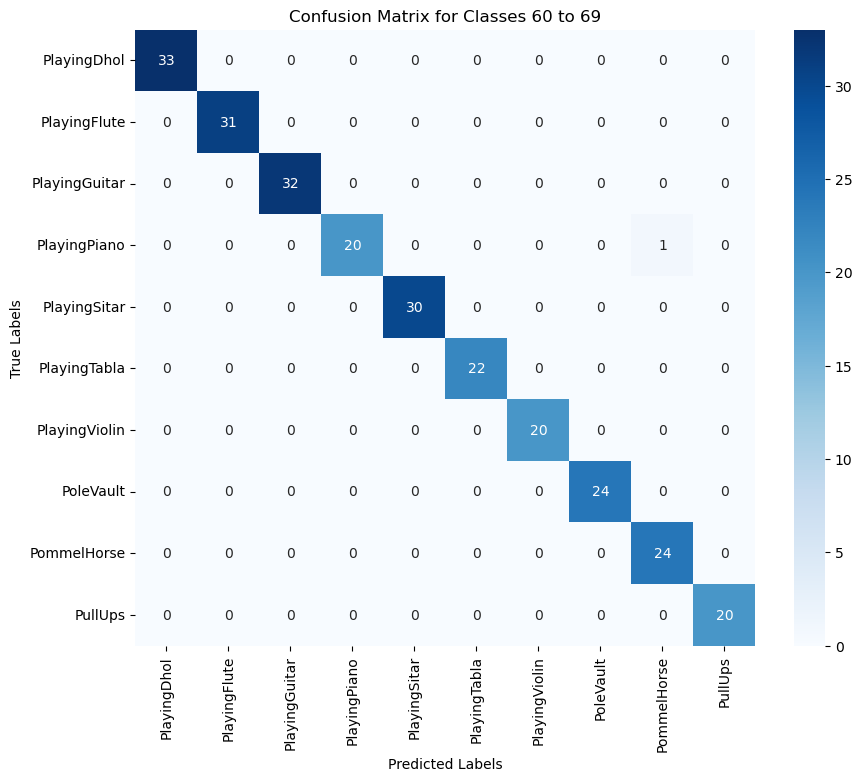

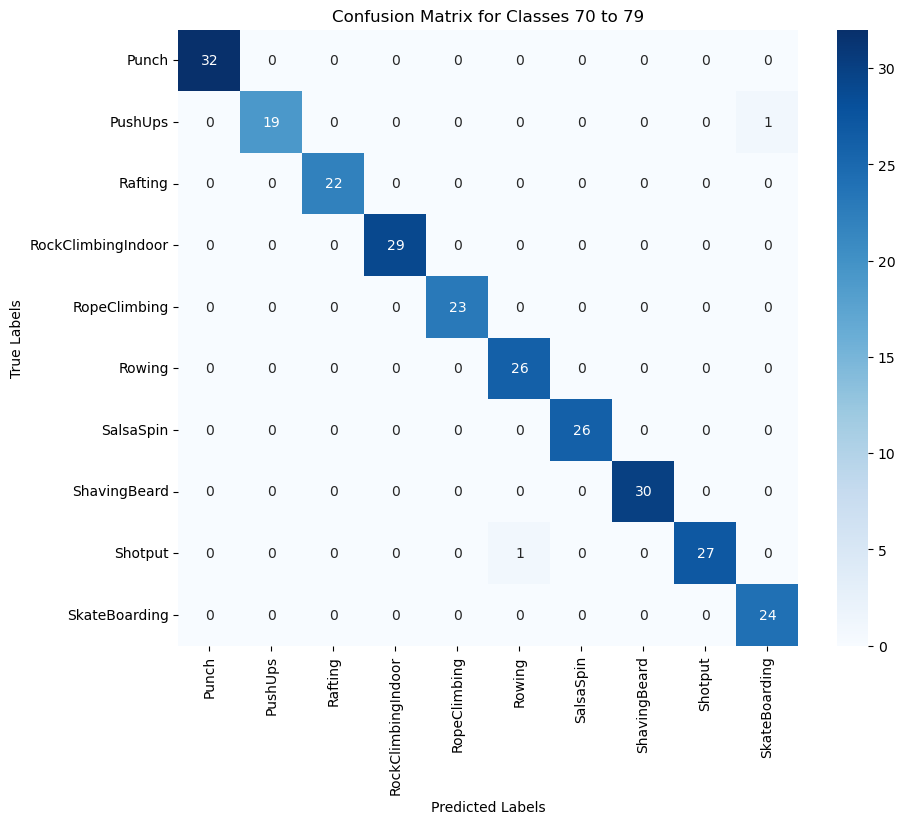

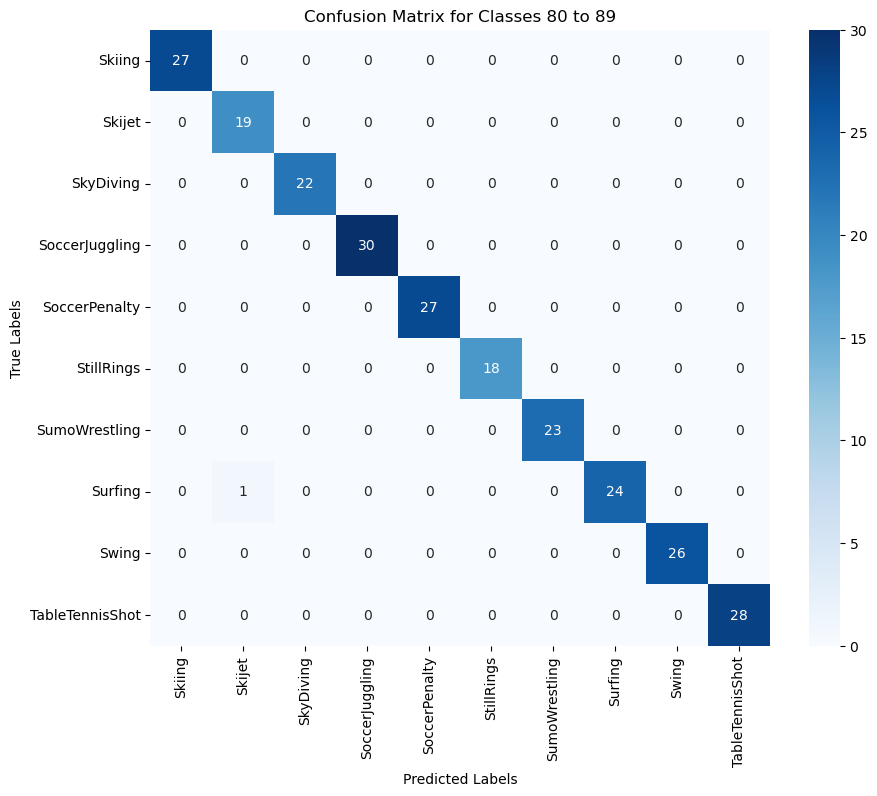

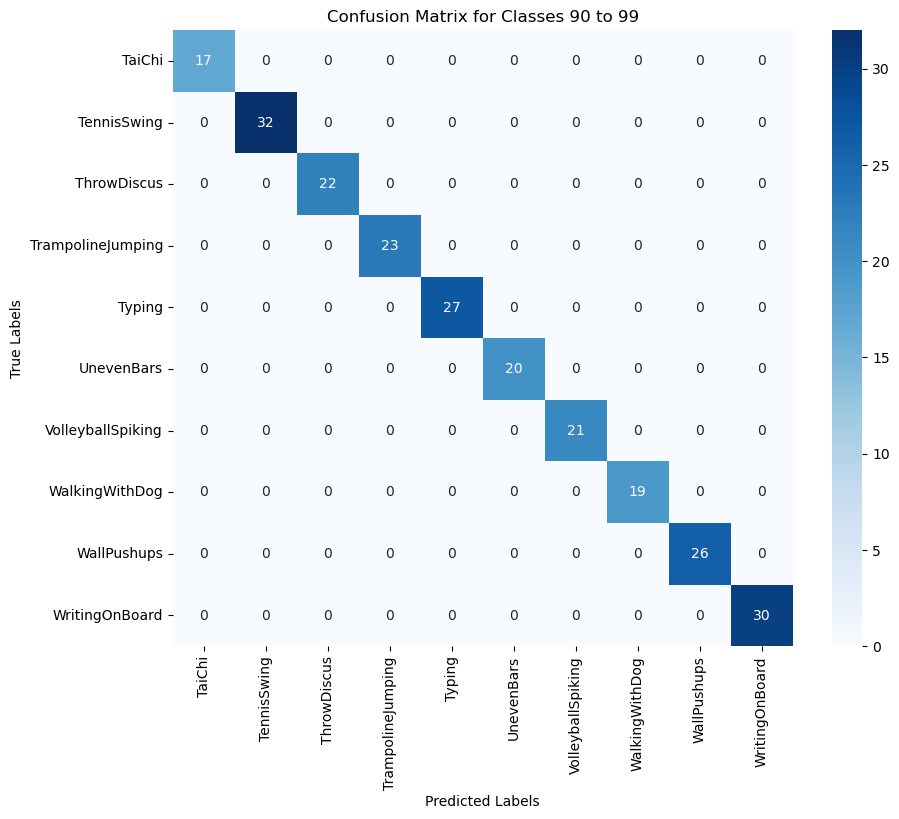

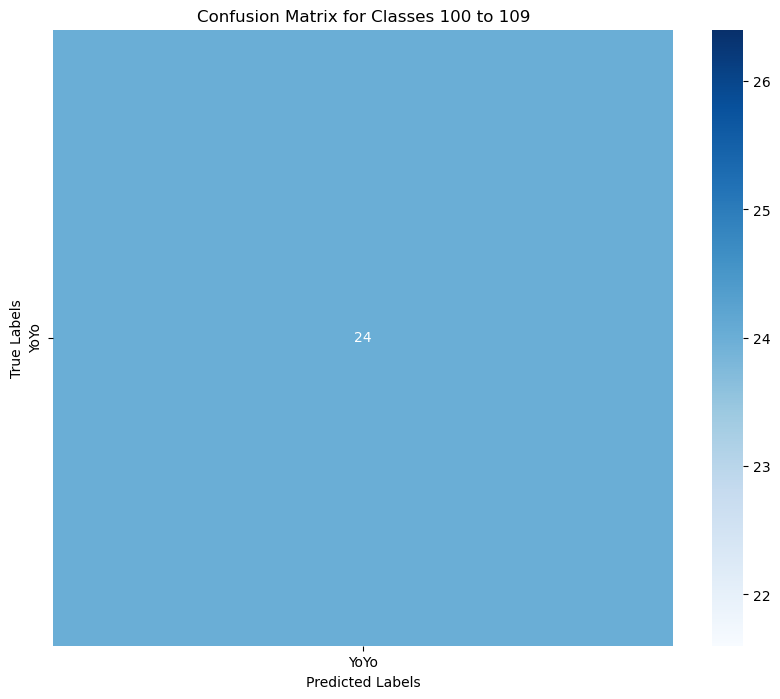

In [90]:
conf_matrix = np.squeeze(conf_matrix)

# Visualise the confusion matrix
# Assuming `class_map` is your dictionary loaded from classInd.txt
# where the key is the class index and the value is the class name
class_names = [class_map[i] for i in range(len(class_map))]

# Now you can visualize the confusion matrix
# Assuming 'conf_matrix' is the confusion matrix and 'class_names' is a list of class names
for i in range(0, len(class_names), 10):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix[i:i+10, i:i+10], annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names[i:i+10], yticklabels=class_names[i:i+10])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for Classes {i} to {i+9}')
    plt.show()


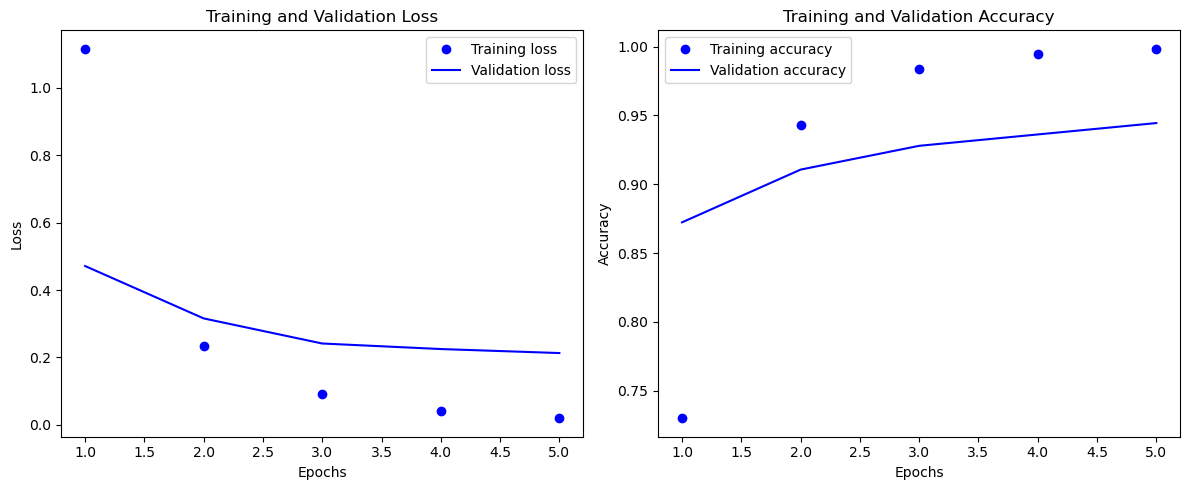

In [91]:
# Assuming 'history' is the output from the model.fit() method
history_dict = history.history

# Extract the loss and accuracy for training and validation sets
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)

# Plot the loss over epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

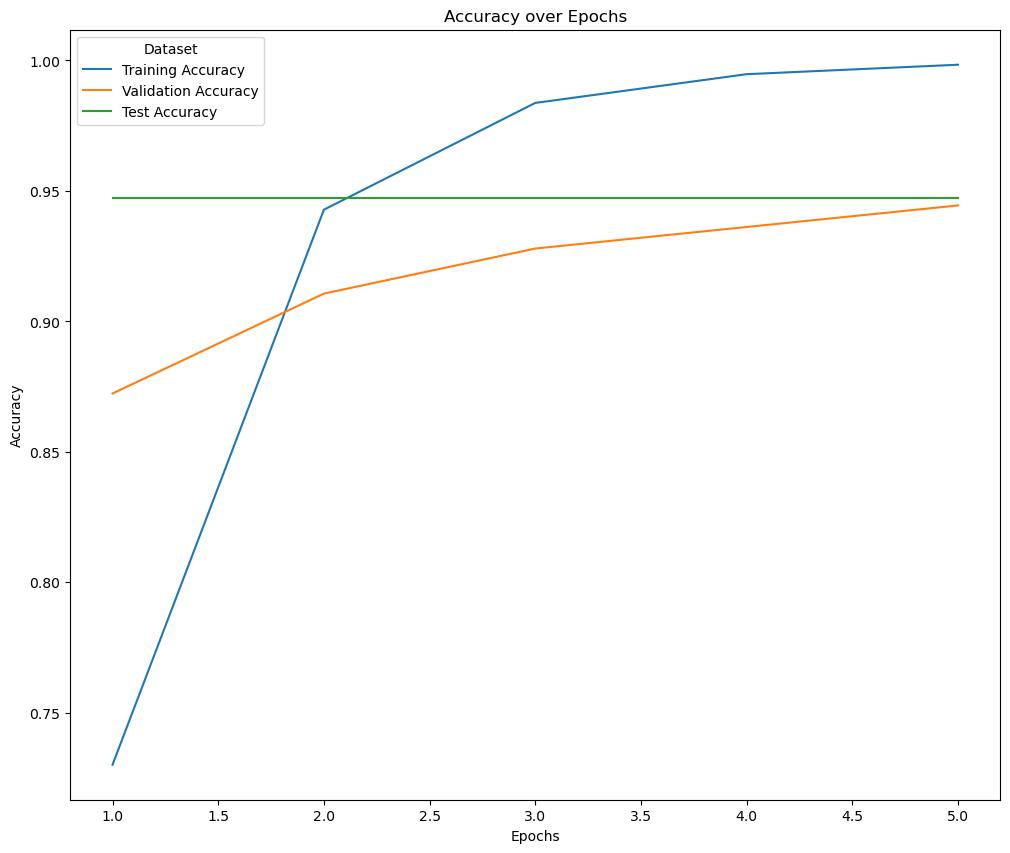

In [92]:
# Create a DataFrame to hold all the accuracy data
accuracy_df = pd.DataFrame({
    'Epoch': epochs,
    'Training Accuracy': accuracy,
    'Validation Accuracy': val_accuracy,
    'Test Accuracy': [test_accuracy] * len(epochs)  # Repeat the test accuracy value
})

# Melt the DataFrame to long format for Seaborn
accuracy_df_long = pd.melt(accuracy_df, 'Epoch', var_name='Dataset', value_name='Accuracy')

# Plot using Seaborn
plt.figure(figsize=(12,10))
sns.lineplot(data=accuracy_df_long, x='Epoch', y='Accuracy', hue='Dataset')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(title='Dataset')
plt.show()